In [1]:
%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'retina'

In [1]:
#%matplotlib notebook

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd
from IPython.display import HTML

In [64]:
pdf = pd.read_csv("../block_data/block_poles_eur_rel.csv")

In [65]:
pdf.index = pdf.mov

In [66]:
pdf.head()

,lon,lat,rotrate,fix,mov
mov,,,,,
2,-69.679690,-31.619923,0.444713,1111,2
3,55.233578,29.736437,0.600839,1111,3
4,58.617357,33.072931,0.656806,1111,4
5,41.796455,31.985239,0.405846,1111,5
6,63.331290,35.228243,0.828967,1111,6


In [67]:
with open("../block_data/chn_blocks.geojson") as f:
    blocks = json.load(f)

In [68]:
def sind(ang):
    return np.sin(np.radians(ang))

def cosd(ang):
    return np.cos(np.radians(ang))

def atand2(y,x):
    return np.degrees(np.arctan2(y,x))

def atand(x):
    return np.degrees(np.arctan(x))


def sphere_to_cart(lon, lat):
    
    r = 1.
    
    x = r * cosd(lat) * cosd(lon)
    y = r * cosd(lat) * sind(lon)
    z = r * sind(lat) 
    
    return np.array([x,y,z])


def cart_to_sphere(x, y, z):
    lon = atand2(y, x)
    lat = atand(z / np.sqrt(x**2 + y**2))
    
    return [lon, lat]


In [69]:
def make_rot_matrix(cpole, ang):
    
    Ex, Ey, Ez = cpole[0], cpole[1], cpole[2]
    
    r11 = Ex * Ex * (1 - cosd(ang)) + cosd(ang)
    r12 = Ex * Ey * (1 - cosd(ang)) - Ez * sind(ang)
    r13 = Ex * Ez * (1 - cosd(ang)) + Ey * sind(ang)
    
    r21 = Ey * Ex * (1 - cosd(ang)) + Ez * sind(ang)
    r22 = Ey * Ey * (1 - cosd(ang)) + cosd(ang)
    r23 = Ey * Ez * (1 - cosd(ang)) - Ex * sind(ang)
    
    r31 = Ez * Ex * (1 - cosd(ang)) - Ey * sind(ang)
    r32 = Ez * Ey * (1 - cosd(ang)) + Ex * sind(ang)
    r33 = Ez * Ez * (1 - cosd(ang)) + cosd(ang)
    
    return [[r11, r12, r13],
            [r21, r22, r23],
            [r31, r32, r33]]

In [70]:
blocks['features'][0]['geometry']['coordinates'][0][0][:10]

[[77.38401535179355, 36.46122614906691],
 [77.50080986152338, 36.446325536193314],
 [77.60730541823762, 36.42748064344141],
 [77.6787407093669, 36.42397461688292],
 [77.73450844431295, 36.41016963730885],
 [77.79301526250781, 36.402609767542096],
 [77.85283684066209, 36.39110561789704],
 [77.95900370738646, 36.368097318606935],
 [77.99877519615937, 36.36250958877933],
 [78.1443848616668, 36.321094650057134]]

In [71]:
def rotate_block(block, time=1):
    trace = block["geometry"]["coordinates"][0][0]
    pole = pdf.loc[block['properties']['fid']]
    
    cpole = sphere_to_cart(pole.lon, pole.lat)
    R = make_rot_matrix(cpole, pole.rotrate * time)
    
    trace_cart = [sphere_to_cart(*tr) for tr in trace]
    
    rot_pts = [(tr @ R) for tr in trace_cart]
    
    new_trace_sphere = [cart_to_sphere(*rp) for rp in rot_pts]
    
    return new_trace_sphere
    

def get_trace_coords(trace):
    return [tr[0] for tr in trace], [tr[1] for tr in trace]

In [72]:
blocks["features"][0]["properties"]

{'fid': 2}

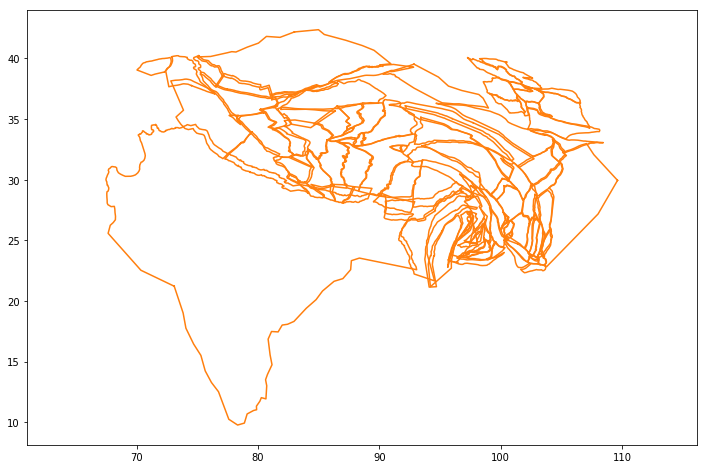

In [73]:
plt.figure(figsize=(12,8))


for block in blocks['features']:

    #plt.plot(*get_trace_coords(block['geometry']['coordinates'][0]), 'C0')

    try:
        plt.plot(*get_trace_coords(rotate_block(block, -5)), 'C1')
    except KeyError:
        pass

plt.axis('equal')

plt.show()

In [74]:
import ipywidgets as widgets
from IPython.display import display

In [75]:
pdf = pd.read_csv("../block_data/block_poles_eur_rel.csv")
pdf.index = pdf.mov

In [76]:
def plot_blocks_at_time(time):
    plt.figure(figsize=(12,8))
    for block in blocks["features"]:
        try:
        #plt.plot(*get_trace_coords(rotate_block(block, -time)), )
            plt.fill(*get_trace_coords(rotate_block(block, -time)), alpha=0.5)
            plt.title("{} Ma".format(-time))
            plt.axis('equal')
        except:
            pass
    
    plt.show()

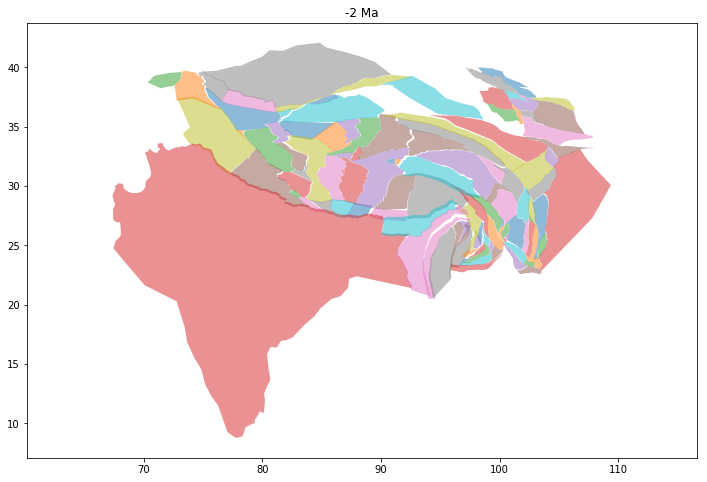

In [77]:
interactive_plot = widgets.interactive(plot_blocks_at_time, time=(-5, 10))
output = interactive_plot.children[-1]
interactive_plot

In [78]:
def plot_blocks_at_time(time):
    plt.figure(figsize=(12,8))
    for block in blocks["features"]:
        try:
        #plt.plot(*get_trace_coords(rotate_block(block, -time)), )
            plt.fill(*get_trace_coords(rotate_block(block, -time)), alpha=0.5)
            plt.title("{} Ma".format(-time))
            plt.axis('equal')
        except:
            pass
    
    plt.show()

done


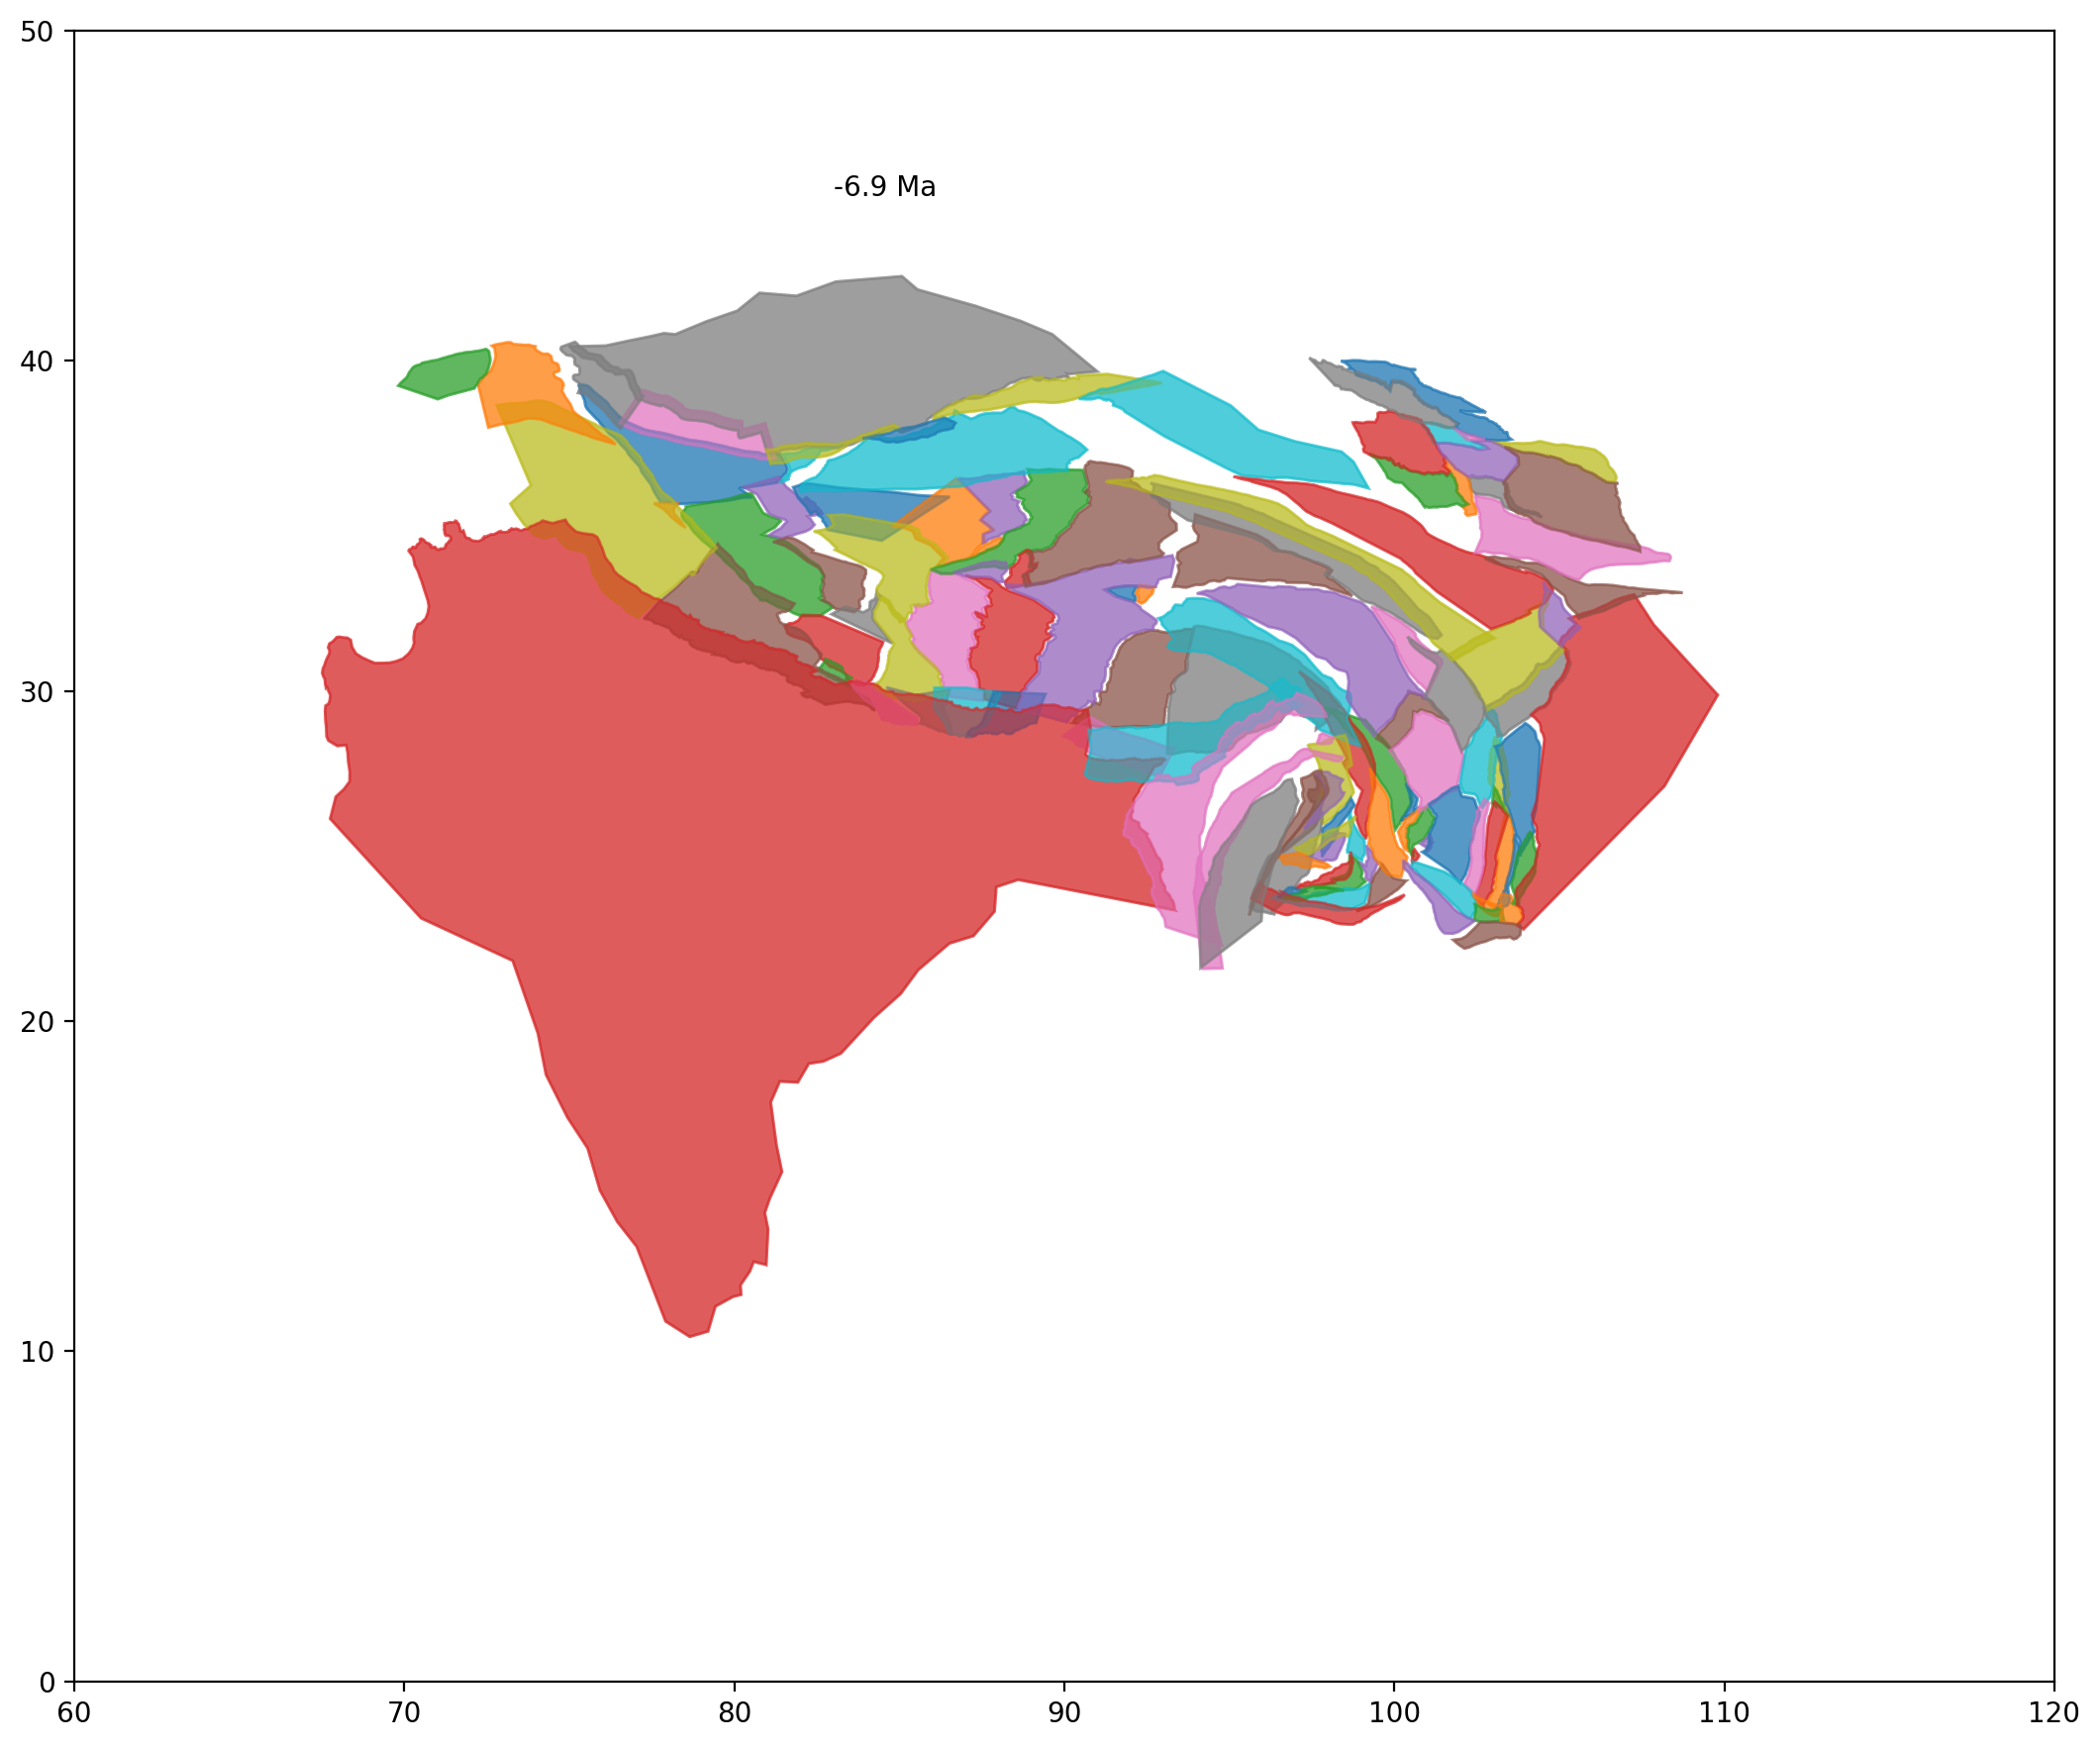

In [79]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.set_dpi(200)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(60, 120), ylim=(0, 50))

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

from itertools import cycle
colors = map('C{}'.format, cycle(range(10)))

polies = [Polygon(rotate_block(block, 0), color=next(colors), alpha=0.5) for block in blocks['features']]

def init():
    #polys = [Polygon(*get_trace_coords(rotate_block(block, 0)))
    #         for block in blocks["features"]]
    global age
    age = ax.text(83, 45, "")
    
    for poly in polies:
        ax.add_patch(poly)
    
    return []


def update_time(i):
    time = 3 + i * -0.1
    age.set_text("{0:.1f} Ma".format(time))
    return age,

def update_poly(i):
    for n, poly in enumerate(polies):
        poly.set_xy(rotate_block(blocks["features"][n], 3 + i * -0.1))
    return polies,

def anim_manag(i):
    update_poly(i)
    update_time(i)


ani = animation.FuncAnimation(fig, anim_manag,
                              frames = 100, init_func=init, blit=False)

#plt.show()

    
#HTML(ani.to_html5_video())
ani.save('../../../../../Desktop/tibet_collision.mp4')

print("done")
    

In [18]:
rotate_block(blocks["features"][0], 0)

[[77.38401535179355, 36.46122614906691],
 [77.50080986152338, 36.44632553619331],
 [77.60730541823762, 36.42748064344141],
 [77.6787407093669, 36.42397461688292],
 [77.73450844431295, 36.41016963730885],
 [77.79301526250781, 36.402609767542096],
 [77.85283684066209, 36.39110561789704],
 [77.95900370738646, 36.368097318606935],
 [77.99877519615937, 36.36250958877934],
 [78.1443848616668, 36.321094650057134],
 [78.19089449523179, 36.309754845407014],
 [78.27668258258493, 36.295621175843095],
 [78.38219206932958, 36.27392763651241],
 [78.42787997791994, 36.26324521184199],
 [78.62312183189604, 36.222487653099506],
 [78.69806314958383, 36.2218302731198],
 [79.09051899747517, 36.17975795441789],
 [79.28799538161007, 36.142155605907455],
 [79.6404173505089, 36.07868578253631],
 [79.72916364777076, 36.06027914310423],
 [79.77715238629013, 36.045816783550436],
 [79.99212920212138, 36.006768512119415],
 [80.25227376663096, 35.954769656359574],
 [80.63057584977116, 35.93635777838722],
 [80.69056